# RR Lyrae / HADS — Fourier‑Fit & Monte‑Carlo‑Analyse
Dieses Notebook zeigt Schritt für Schritt, wie man aus einer Lichtkurve
die Periode bestimmt, einen Fourier‑Fit anlegt und anschließend per
Monte‑Carlo‑Sampling den Fehler auf den Zeitpunkt des Maximums oder Minimums
abschätzt.

**Benötigte Bibliotheken**: numpy, pandas, matplotlib, scipy, astropy
(alle in Anaconda / Miniforge verfügbar).

## 1 · Daten einlesen

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
from pathlib import Path

# ---- Pfad zur Lichtkurve anpassen ----
DATA_PATH = Path('data') / 'lc_obs.csv' # CSV mit Spalten: time, mag, (optional) mag_err
df = pd.read_csv(DATA_PATH)
t  = df['HJD'].values
y  = df['MAG' ].values
yerr = df['MERR'].values if 'MERR' in df.columns else None

# Sortieren und ggf. Nullpunkt setzen
order = np.argsort(t)
t, y = t[order], y[order]
t0 = t.min()
t  = t - t0  # Start bei t=0

print(f'Datenpunkte: {len(t)}  |  Beobachtungsdauer: {t.max():.2f} d')

Datenpunkte: 62  |  Beobachtungsdauer: 0.10 d


## 2 · Periode suchen (Lomb–Scargle)

Gefundene Periode: 0.090532 d  (f = 11.0458 d⁻¹)


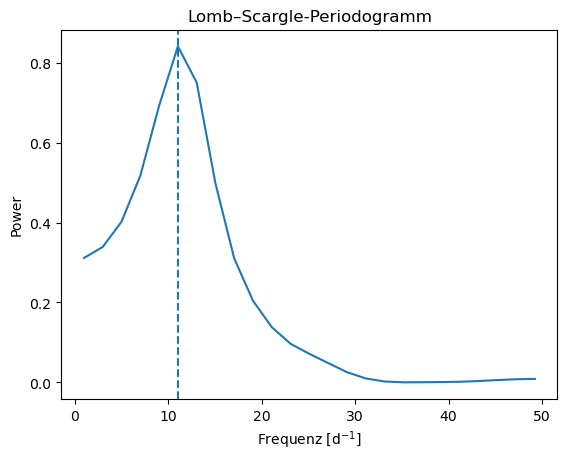

In [10]:
# Frequenzfenster grob um RR/HADS (1–50 d⁻¹)
freq, power = LombScargle(t, y, dy=yerr).autopower(minimum_frequency=1, maximum_frequency=50)
f0 = freq[np.argmax(power)]
P0 = 1 / f0
print(f'Gefundene Periode: {P0:.6f} d  (f = {f0:.4f} d⁻¹)')

# Plot Periodogramm
plt.figure()
plt.plot(freq, power)
plt.axvline(f0, ls='--')
plt.xlabel('Frequenz [d$^{-1}$]'); plt.ylabel('Power'); plt.title('Lomb–Scargle‑Periodogramm');
plt.show()

## 3 · Fourier‑Modell definieren

In [11]:
def fourier(t, *amp_sin_cos):
    """
    Fourier‐Reihe mit beliebig vielen Harmonischen, getrennt nach Sinus und Kosinus.
    P: Periode
    amp_sin_cos: [A0, A1_sin, A1_cos, A2_sin, A2_cos, ...]
    """
    w = 2*np.pi / P0
    y = amp_sin_cos[0]  # A0 (Offset)
    n_harm = (len(amp_sin_cos) - 1) // 2
    for k in range(1, n_harm + 1):
        A_sin = amp_sin_cos[2*k-1]
        A_cos = amp_sin_cos[2*k]
        y += A_sin * np.sin(k * w * t) + A_cos * np.cos(k * w * t)
    return y

## 3 · Fit ausführen

Beste Parameter (Periode fixiert):
  p[0] =  0.090532 (fixiert)
  p[1] =  11.731429
  p[2] =  0.135787
  p[3] = -0.056166
  p[4] = -0.003769
  p[5] =  0.056194
  p[6] = -0.017130
  p[7] = -0.013327


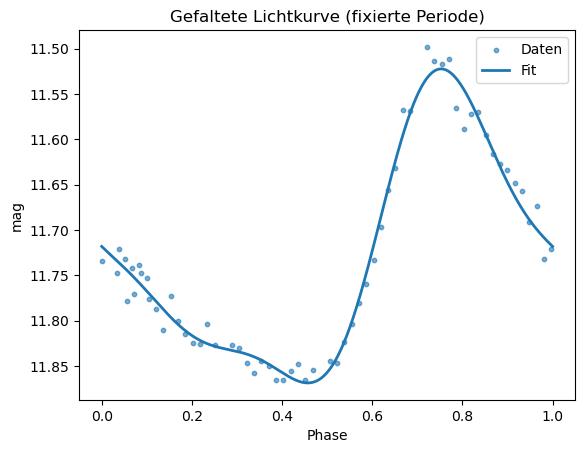

In [12]:
# Anzahl Harmonische anpassen (z. B. 4 für RRab, 2 für HADS)
n_harm = 3
A0_guess = np.median(y)
amp_sin_cos0 = [A0_guess] + [0.1, 0.1] * n_harm

popt_coeffs, pcov_coeffs = curve_fit(fourier, t, y, p0=amp_sin_cos0, sigma=yerr, absolute_sigma=False, maxfev=10000)

# KORREKTUR: Verwende nur die Fourier-Koeffizienten, nicht die fixierte Periode
popt = np.array(list(popt_coeffs))
pcov = pcov_coeffs  

print('Beste Parameter (Periode fixiert):')
print(f'  p[0] = {P0: .6f} (fixiert)')
for i, p in enumerate(popt_coeffs):
    print(f'  p[{i+1}] = {p: .6f}')

# Modellplot
phase = (t % P0) / P0
t_fit = np.linspace(0, P0, 2000)
plt.figure()
plt.scatter(phase, y, s=10, alpha=0.6, label='Daten')
plt.plot(t_fit/P0, fourier(t_fit, *popt), lw=2, label='Fit')
plt.gca().invert_yaxis()
plt.xlabel('Phase'); plt.ylabel('mag'); plt.title('Gefaltete Lichtkurve (fixierte Periode)'); plt.legend();
plt.show()

In [13]:
import numpy.random as npr

def t_max_from_params(params, n_grid=2000):
    ts = np.linspace(0, P0, n_grid)
    y = fourier(ts, *params)
    return ts[np.argmin(y)]  # Minimum in mag = Maximum in Lichtstrom

n_samples = 10000
rng = npr.default_rng(42)
samples = rng.multivariate_normal(mean=popt, cov=pcov, size=n_samples)
tmax_samples = np.array([t_max_from_params(par) for par in samples])

# Auf Intervall [0, P) klappen
tmax_samples = (tmax_samples + popt[0]) % popt[0]

tmax_est = t_max_from_params(popt)
sigma_tmax = tmax_samples.std(ddof=1)
print(f't_max = {tmax_est + t0:.6f} ± {sigma_tmax:.6f} d (absolutes JD‐Zero‐Level)')

t_max = 2460793.468254 ± 0.000319 d (absolutes JD‐Zero‐Level)


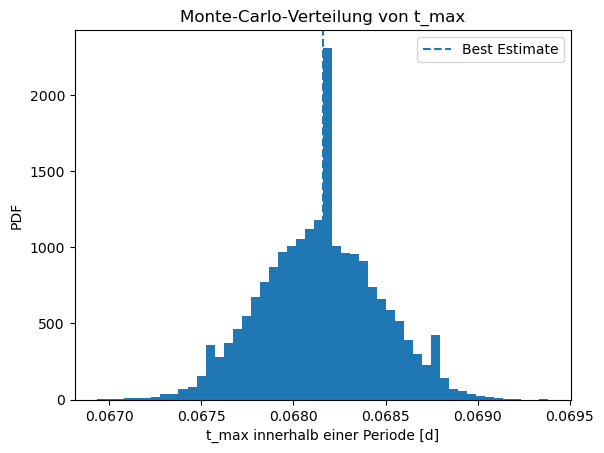

In [14]:
# Histogramm
plt.figure()
plt.hist(tmax_samples, bins=50, density=True)
plt.axvline(tmax_est, ls='--', label='Best Estimate')
plt.xlabel('t_max innerhalb einer Periode [d]'); plt.ylabel('PDF');
plt.title('Monte‑Carlo‑Verteilung von t_max');
plt.legend();
plt.show()

In [15]:
# Synthetische Lichtkurve generieren und als CSV exportieren
import pandas as pd
t_synth = np.linspace(t.min(),t.max(), 1000)
mag_synth = fourier(t_synth, *popt)
df_synth = pd.DataFrame({
    "HJD": t_synth + t0,
    "MAG": mag_synth
})
df_synth.to_csv("./data/lc_synth.csv", index=False)
print("Synthetische Lichtkurve als ./data/lc_synth_rr.csv gespeichert.")

Synthetische Lichtkurve als ./data/lc_synth_rr.csv gespeichert.


In [16]:
# Unsicherheit von t_max im exoplanet_fit-Format ausgeben und speichern
import pandas as pd
mean_tm = float(tmax_samples.mean() + t0)
sd_tm   = float(tmax_samples.std(ddof=1))
hdi_3  = float(np.percentile(tmax_samples + t0, 3))
hdi_97 = float(np.percentile(tmax_samples + t0, 97))
df_unc = pd.DataFrame({
    "parameter": ["tm"],
    "mean": [mean_tm],
    "sd": [sd_tm],
    "hdi_3%": [hdi_3],
    "hdi_97%": [hdi_97]
})
df_unc.to_csv("./data/uncertainties.csv", index=False)
print(df_unc)

  parameter          mean        sd        hdi_3%       hdi_97%
0        tm  2.460793e+06  0.000319  2.460793e+06  2.460793e+06
